## EDA on song features 

## Song Features :

**Danceability**: Describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm
stability, beat strength, and overall regularity.<br>

**Valence**: Describes the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry). <br>


**Energy**: Represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale.<br>

**Tempo**: The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece, and derives directly from the average beat duration. <br>

**Loudness**: The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. <br>

**Speechiness**: This detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. <br>

**Instrumentalness**: Predicts whether a track contains no vocals. “Ooh” and “aah” sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly “vocal”. <br>

**Liveness**: Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. <br>

**Acousticness**: A confidence measure from 0.0 to 1.0 of whether the track is acoustic. <br>

**Key**: The estimated overall key of the track. Integers map to pitches using standard Pitch Class notation . E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on. <br>

**Mode**: Indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0. <br>

**Duration**: The duration of the track in milliseconds. <br>

**Time Signature**: An estimated overall time signature of a track. The time signature (meter) is a notational convention to specify how many beats are in each bar (or measure). <br>


In [8]:
pip install pymysql

  Using cached PyMySQL-1.0.2-py3-none-any.whl (43 kB)
Note: you may need to restart the kernel to use updated packages.


In [64]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
import sqlalchemy as db
import pymysql

In [10]:
host = "127.0.0.1"         
user = "root"          
passwd = "root"    
database = "srecommend"     

engine = db.create_engine(f'mysql+pymysql://{user}:{passwd}@{host}/{database}')
audio_features = pd.read_sql_table('song_features',engine)

In [11]:
connection = engine.connect()
metadata = db.MetaData()
song_feature = db.Table('song_features', metadata, autoload=True, autoload_with=engine)

In [12]:
# query = db.select([song_feature.columns.Performer,song_feature.columns.Song,song_feature.columns.spotify_track_id]).where(song_feature.columns.Song.like(value) )
# Result = connection.execute(query).fetchall()

In [13]:
# value = "ready"
# value = "%" + value + "%"
# query = db.select([song_feature.columns.Performer,song_feature.columns.Song,song_feature.columns.spotify_track_id]).where(song_feature.columns.Song.like(value) )
# Result = connection.execute(query).fetchall()

# result = []
# for row in list(ResultProxy):
#     artist = row[0]
#     song = row[1]
    
#     SongFull = song + " - " + artist
#     result.append(SongFull)

In [14]:
# query = db.select([
#     song_feature.c.Song
# ]).where(song_feature.columns.Song.like('%thund%') )
  
# # Fetch all the records
# result = engine.execute(query).fetchall()

- We will remove "liveness" , "speechiness" and "instrumentalness","acousticness" because they are representing probability unless we convert them into categorical variable but to reduce features we would focus on other features
- We don't want track id either 

In [15]:
audio_features.drop(['speechiness',"instrumentalness","liveness",'spotify_track_id','acousticness'],axis= 1 , inplace = True)

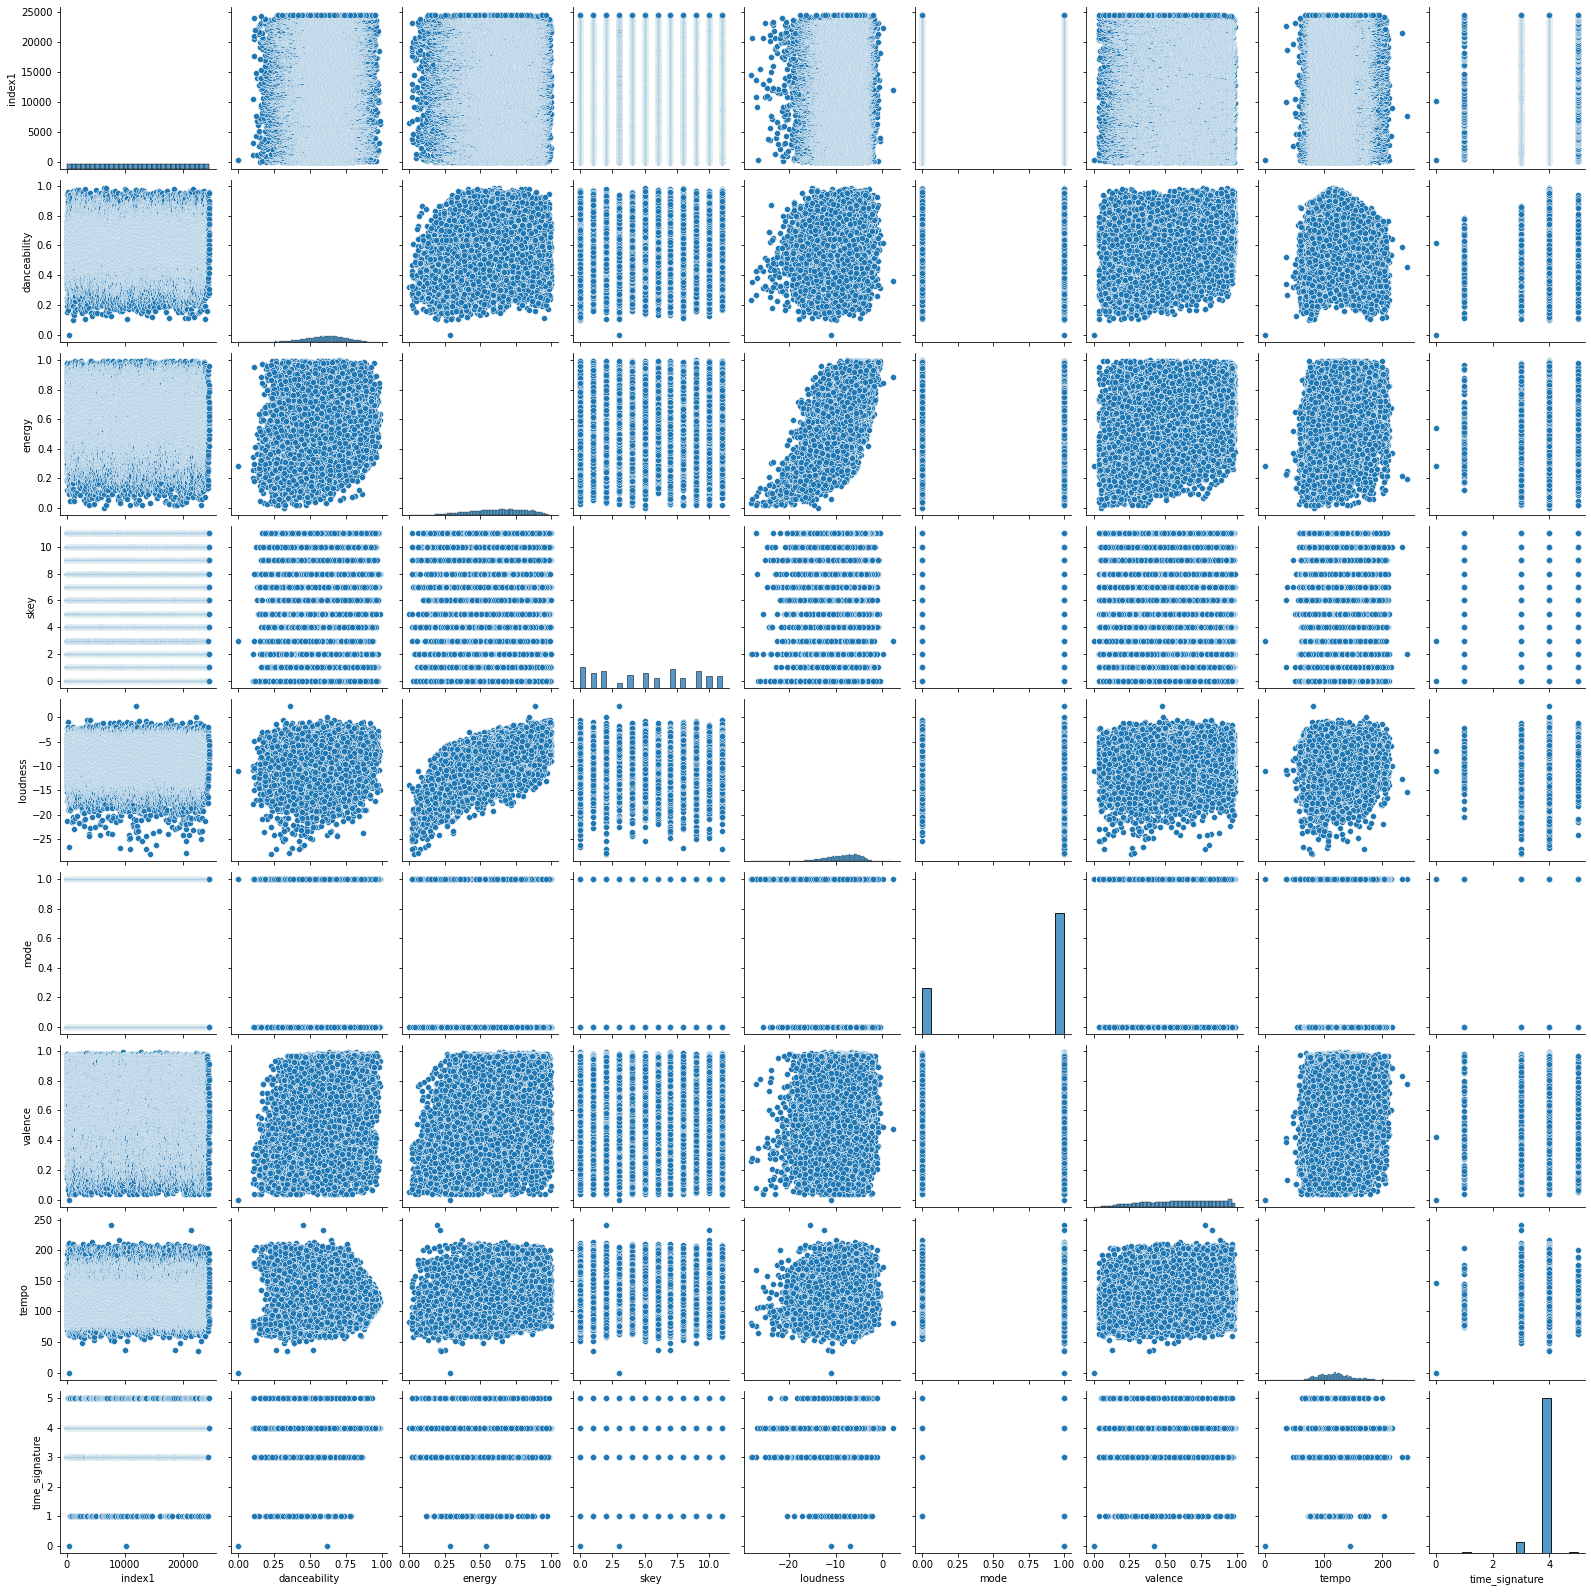

In [16]:
sns.pairplot(audio_features)

<AxesSubplot:>

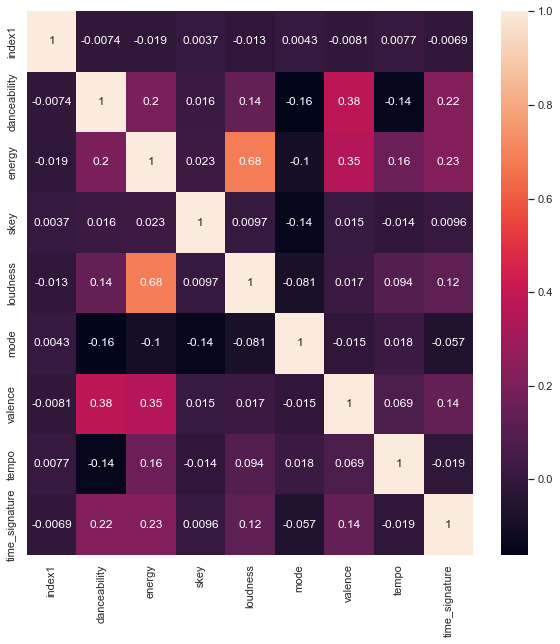

In [17]:
sns.set(rc={'figure.figsize' : (10,10)})
corr = audio_features.corr()
sns.heatmap(corr,annot = True)

There is high corelation between loudness and energy so we can do PCA but for simplicity's sake we gonna keep it.

In [87]:
data = audio_features.iloc[:,1:].copy()

In [88]:
data['spotify_genre'] = data['spotify_genre'].apply(lambda x :  tuple(x.strip().split(',')) ) 

In [89]:
data['spotify_genre']

0        (adult standards, brill building pop, easy lis...
1                                         (rock-and-roll,)
2                          (dance pop, pop, post-teen pop)
3                                     (pop, post-teen pop)
4        (album rock, bubblegum pop, country rock, folk...
                               ...                        
24499                                             (other,)
24500                                             (other,)
24501                                             (other,)
24502                                             (other,)
24503                                       (pop, pop rap)
Name: spotify_genre, Length: 24504, dtype: object

In [90]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MultiLabelBinarizer,MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin 

In [91]:

class MultiHotEncoder(BaseEstimator, TransformerMixin):
    """Wraps `MultiLabelBinarizer` in a form that can work with `ColumnTransformer`.
    Note that input X has to be a `pandas.DataFrame`.
    """
    def __init__(self):
        self.mlbs = list()
        self.n_columns = 0
        self.categories_ = self.classes_ = list()

    def fit(self, X:pd.DataFrame, y=None):
        for i in range(X.shape[1]): # X can be of multiple columns
            mlb = MultiLabelBinarizer()
            mlb.fit(X.iloc[:,i])
            self.mlbs.append(mlb)
            self.classes_.append(mlb.classes_)
            self.n_columns += 1
        return self

    def transform(self, X:pd.DataFrame):
        if self.n_columns == 0:
            raise ValueError('Please fit the transformer first.')
        if self.n_columns != X.shape[1]:
            raise ValueError(f'The fit transformer deals with {self.n_columns} columns '
                             f'while the input has {X.shape[1]}.'
                            )
        result = list()
        for i in range(self.n_columns):
            result.append(self.mlbs[i].transform(X.iloc[:,i]))

        result = np.concatenate(result, axis=1)
        return result

In [92]:
def train(data):
    model = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=6)
    model.fit(data)
    return model

def get_neighbors(transformer,data): 
    train_data = data.iloc[:,2:]
    train_data = transformer.fit_transform(train_data)
    model = train(train_data)
    test(model,data,train_data)
    
def test(model,data,train_data):
    
    index = [3,10,24411,17303,6402,15440,1426,8367]

    for i in index:
        distance, indices  = model.kneighbors(train_data[i].reshape(1,train_data[i].shape[0]),n_neighbors = 6)
        result = data.iloc[indices[0]]
        display(result)

### Model 1

In [93]:
data1 = data.iloc[:,2:]

In [94]:
data1

,spotify_genre,danceability,energy,skey,loudness,mode,valence,tempo,time_signature
0,"(adult standards, brill building pop, easy lis...",0.154,0.185,5.0,-14.063,1.0,0.150,83.969,4.0
1,"(rock-and-roll,)",0.588,0.672,11.0,-17.278,0.0,0.801,121.962,4.0
2,"(dance pop, pop, post-teen pop)",0.759,0.699,0.0,-5.745,0.0,0.907,92.960,4.0
3,"(pop, post-teen pop)",0.613,0.764,2.0,-6.509,1.0,0.417,160.015,4.0
4,"(album rock, bubblegum pop, country rock, folk...",0.647,0.686,2.0,-4.247,0.0,0.952,155.697,4.0
...,...,...,...,...,...,...,...,...,...
24499,"(other,)",0.859,0.596,11.0,-7.021,1.0,0.479,140.064,4.0
24500,"(other,)",0.853,0.467,9.0,-6.843,0.0,0.329,87.023,4.0
24501,"(other,)",0.742,0.527,8.0,-6.892,0.0,0.638,84.974,4.0
24502,"(other,)",0.671,0.673,11.0,-6.941,0.0,0.494,121.963,4.0


In [95]:
trf1 = ColumnTransformer(transformers =[
    ('genre_transform',  MultiHotEncoder(),['spotify_genre']),
    ('ohe', OneHotEncoder(sparse = False, drop ='first'), ['skey','time_signature']),
    ('scaler', MinMaxScaler(), ['tempo','loudness'])
    
], remainder ='passthrough')

In [96]:
get_neighbors(trf1,data)

C:\Users\Lohiya\miniconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Lohiya\miniconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Lohiya\miniconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Lohiya\miniconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Lohiya\

,artist,song,spotify_genre,danceability,energy,skey,loudness,mode,valence,tempo,time_signature
3,Taylor Swift,...Ready For It?,"(pop, post-teen pop)",0.613,0.764,2.0,-6.509,1.0,0.417,160.015,4.0
12696,Taylor Swift,Love Story (Taylor's Version),"(pop, post-teen pop)",0.627,0.792,2.0,-4.311,1.0,0.415,119.054,4.0
15154,Taylor Swift,Our Song,"(pop, post-teen pop)",0.543,0.686,2.0,-4.751,1.0,0.555,177.874,4.0
1636,Taylor Swift,Back To December,"(pop, post-teen pop)",0.529,0.670,2.0,-4.663,1.0,0.286,141.893,4.0
12697,Taylor Swift,Love Story,"(pop, post-teen pop)",0.618,0.741,2.0,-3.950,1.0,0.296,118.984,4.0
18843,Taylor Swift,Style,"(pop, post-teen pop)",0.598,0.786,2.0,-5.572,1.0,0.456,95.021,4.0


,artist,song,spotify_genre,danceability,energy,skey,loudness,mode,valence,tempo,time_signature
10,Taylor Swift,'Tis The Damn Season,"(pop, post-teen pop)",0.575,0.434,5.0,-8.193,1.0,0.348,145.916,4.0
15386,Taylor Swift,Peace,"(pop, post-teen pop)",0.647,0.272,5.0,-12.906,1.0,0.339,150.044,4.0
17599,Harry Styles,Sign Of The Times,"(pop, post-teen pop)",0.516,0.595,5.0,-4.630,1.0,0.222,119.972,4.0
13135,Taylor Swift,Marjorie,"(pop, post-teen pop)",0.535,0.561,5.0,-11.609,1.0,0.287,96.103,4.0
21758,Taylor Swift,Untouchable,"(pop, post-teen pop)",0.415,0.432,5.0,-6.700,1.0,0.312,199.965,4.0
1430,Taylor Swift,August,"(pop, post-teen pop)",0.532,0.623,5.0,-9.208,1.0,0.403,89.937,4.0


,artist,song,spotify_genre,danceability,energy,skey,loudness,mode,valence,tempo,time_signature
24411,Taylor Swift,Starlight (Taylor's Version),"(pop, post-teen pop)",0.628,0.685,4.0,-5.864,1.0,0.605,126.014,4.0
24408,Taylor Swift,The Lucky One (Taylor's Version),"(pop, post-teen pop)",0.686,0.571,4.0,-7.138,1.0,0.538,117.889,4.0
13407,Bazzi,Mine,"(pop, post-teen pop)",0.710,0.789,4.0,-3.874,1.0,0.717,142.929,4.0
20437,Taylor Swift,The Story Of Us,"(pop, post-teen pop)",0.543,0.818,4.0,-3.611,1.0,0.683,139.898,4.0
24403,Taylor Swift,Babe (Taylor's Version) (From The Vault),"(pop, post-teen pop)",0.584,0.743,4.0,-7.075,1.0,0.746,167.844,4.0
13249,Taylor Swift,Mean,"(pop, post-teen pop)",0.568,0.761,4.0,-3.987,1.0,0.789,163.974,4.0


,artist,song,spotify_genre,danceability,energy,skey,loudness,mode,valence,tempo,time_signature
17303,Ed Sheeran,Shape Of You,"(pop,)",0.825,0.652,1.0,-3.183,0.0,0.931,95.977,4.0
22436,Ed Sheeran,What Do I Know?,"(pop,)",0.838,0.492,1.0,-5.690,0.0,0.895,115.092,4.0
1525,Smith,Baby It's You,"(pop,)",0.593,0.463,1.0,-10.648,0.0,0.694,95.398,4.0
11676,Alec Benjamin Featuring Alessia Cara,Let Me Down Slowly,"(pop,)",0.652,0.557,1.0,-5.714,0.0,0.483,150.073,4.0
11850,Avicii,Levels,"(pop,)",0.596,0.878,1.0,-5.923,0.0,0.461,126.043,4.0
21218,Melanie Martinez,Too Close,"(pop,)",0.618,0.653,1.0,-5.437,0.0,0.311,112.953,4.0


,artist,song,spotify_genre,danceability,energy,skey,loudness,mode,valence,tempo,time_signature
6402,Ed Sheeran,Galway Girl,"(pop,)",0.624,0.876,9.0,-3.374,1.0,0.781,99.943,4.0
7681,Avicii,Heaven,"(pop,)",0.592,0.873,9.0,-5.650,1.0,0.516,122.011,4.0
22415,Smith,What Am I Gonna Do,"(pop,)",0.408,0.738,9.0,-6.792,1.0,0.838,151.219,4.0
24254,Billie Eilish,I Didn't Change My Number,"(pop,)",0.849,0.480,9.0,-5.835,1.0,0.677,142.021,4.0
9021,Lauv,I Like Me Better,"(pop,)",0.752,0.505,9.0,-7.621,1.0,0.419,91.970,4.0
19749,Ed Sheeran,The A Team,"(pop,)",0.642,0.289,9.0,-9.918,1.0,0.407,84.996,4.0


,artist,song,spotify_genre,danceability,energy,skey,loudness,mode,valence,tempo,time_signature
15440,Ed Sheeran,Perfect,"(pop,)",0.599,0.448,8.0,-6.312,1.0,0.1680,95.050,3.0
24189,blackbear,Do Re Mi,"(pop, pop rap)",0.745,0.593,8.0,-6.350,1.0,0.1700,111.001,3.0
4494,Blackbear,Do Re Mi,"(pop, pop rap)",0.742,0.599,8.0,-6.256,1.0,0.1540,110.977,3.0
12986,Ed Sheeran,Make It Rain,"(pop,)",0.618,0.239,8.0,-8.371,0.0,0.3270,96.846,3.0
24250,Billie Eilish,Happier Than Ever,"(pop,)",0.332,0.225,0.0,-8.697,1.0,0.2970,81.055,3.0
21664,Lana Del Rey,Ultraviolence,"(pop,)",0.144,0.541,0.0,-7.076,1.0,0.0899,79.262,3.0


,artist,song,spotify_genre,danceability,energy,skey,loudness,mode,valence,tempo,time_signature
1426,Charlie Puth,Attention,"(dance pop, pop, post-teen pop)",0.775,0.613,3.0,-4.586,0.0,0.797,100.066,4.0
6024,Ariana Grande,Focus,"(dance pop, pop, post-teen pop)",0.681,0.879,3.0,-6.006,0.0,0.818,99.955,4.0
18813,The Cheetah Girls,Strut,"(dance pop, pop, post-teen pop)",0.674,0.870,3.0,-5.158,0.0,0.559,120.027,4.0
769,Justin Bieber Featuring Ludacris,All Around The World,"(canadian pop, dance pop, pop, post-teen pop)",0.689,0.816,3.0,-3.951,0.0,0.775,127.958,4.0
4760,P!nk,Don't Let Me Get Me,"(dance pop, pop, post-teen pop)",0.621,0.849,3.0,-4.754,1.0,0.620,98.523,4.0
5690,P!nk,Family Portrait,"(dance pop, pop, post-teen pop)",0.762,0.686,0.0,-5.260,0.0,0.733,91.816,4.0


,artist,song,spotify_genre,danceability,energy,skey,loudness,mode,valence,tempo,time_signature
8367,Charlie Puth,How Long,"(dance pop, pop, post-teen pop)",0.845,0.561,1.0,-5.253,0.0,0.811,109.974,4.0
13155,Charlie Puth Featuring Meghan Trainor,Marvin Gaye,"(dance pop, pop, post-teen pop)",0.795,0.616,1.0,-5.281,0.0,0.815,110.015,4.0
12744,Selena Gomez & The Scene,Love You Like A Love Song,"(dance pop, pop, post-teen pop)",0.858,0.678,1.0,-3.870,0.0,0.922,117.009,4.0
23144,Alessia Cara,Wild Things,"(dance pop, pop, post-teen pop)",0.741,0.626,1.0,-4.826,0.0,0.706,108.029,4.0
1809,Ariana Grande,Be Alright,"(dance pop, pop, post-teen pop)",0.813,0.456,1.0,-7.667,0.0,0.587,108.801,4.0
14393,Niall Horan,No Judgement,"(dance pop, pop, post-teen pop)",0.723,0.726,1.0,-3.835,0.0,0.962,100.051,4.0


Results are not desireble 

## Model 2 

Let's See if removing Mode makes any difference or not!

In [97]:
model2_data = data.copy()

In [98]:
model2_data.drop('time_signature',axis = 1,inplace = True) 

In [99]:
trf2 = ColumnTransformer(transformers =[
    ('genre_transform',  MultiHotEncoder(),['spotify_genre']),
    ('ohe', OneHotEncoder(sparse = False, drop ='first'), ['skey']),
    ('scaler', MinMaxScaler(), ['tempo','loudness'])
], remainder ='passthrough')

In [100]:
get_neighbors(trf2,model2_data)

C:\Users\Lohiya\miniconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Lohiya\miniconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Lohiya\miniconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Lohiya\miniconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Lohiya\

,artist,song,spotify_genre,danceability,energy,skey,loudness,mode,valence,tempo
3,Taylor Swift,...Ready For It?,"(pop, post-teen pop)",0.613,0.764,2.0,-6.509,1.0,0.417,160.015
12696,Taylor Swift,Love Story (Taylor's Version),"(pop, post-teen pop)",0.627,0.792,2.0,-4.311,1.0,0.415,119.054
15154,Taylor Swift,Our Song,"(pop, post-teen pop)",0.543,0.686,2.0,-4.751,1.0,0.555,177.874
1636,Taylor Swift,Back To December,"(pop, post-teen pop)",0.529,0.670,2.0,-4.663,1.0,0.286,141.893
12697,Taylor Swift,Love Story,"(pop, post-teen pop)",0.618,0.741,2.0,-3.950,1.0,0.296,118.984
18843,Taylor Swift,Style,"(pop, post-teen pop)",0.598,0.786,2.0,-5.572,1.0,0.456,95.021


,artist,song,spotify_genre,danceability,energy,skey,loudness,mode,valence,tempo
10,Taylor Swift,'Tis The Damn Season,"(pop, post-teen pop)",0.575,0.434,5.0,-8.193,1.0,0.348,145.916
15386,Taylor Swift,Peace,"(pop, post-teen pop)",0.647,0.272,5.0,-12.906,1.0,0.339,150.044
17599,Harry Styles,Sign Of The Times,"(pop, post-teen pop)",0.516,0.595,5.0,-4.630,1.0,0.222,119.972
13135,Taylor Swift,Marjorie,"(pop, post-teen pop)",0.535,0.561,5.0,-11.609,1.0,0.287,96.103
21758,Taylor Swift,Untouchable,"(pop, post-teen pop)",0.415,0.432,5.0,-6.700,1.0,0.312,199.965
7662,Conan Gray,Heather,"(pop, post-teen pop)",0.357,0.425,5.0,-7.301,1.0,0.270,102.078


,artist,song,spotify_genre,danceability,energy,skey,loudness,mode,valence,tempo
24411,Taylor Swift,Starlight (Taylor's Version),"(pop, post-teen pop)",0.628,0.685,4.0,-5.864,1.0,0.605,126.014
24408,Taylor Swift,The Lucky One (Taylor's Version),"(pop, post-teen pop)",0.686,0.571,4.0,-7.138,1.0,0.538,117.889
13407,Bazzi,Mine,"(pop, post-teen pop)",0.710,0.789,4.0,-3.874,1.0,0.717,142.929
20437,Taylor Swift,The Story Of Us,"(pop, post-teen pop)",0.543,0.818,4.0,-3.611,1.0,0.683,139.898
24403,Taylor Swift,Babe (Taylor's Version) (From The Vault),"(pop, post-teen pop)",0.584,0.743,4.0,-7.075,1.0,0.746,167.844
13249,Taylor Swift,Mean,"(pop, post-teen pop)",0.568,0.761,4.0,-3.987,1.0,0.789,163.974


,artist,song,spotify_genre,danceability,energy,skey,loudness,mode,valence,tempo
17303,Ed Sheeran,Shape Of You,"(pop,)",0.825,0.652,1.0,-3.183,0.0,0.931,95.977
22436,Ed Sheeran,What Do I Know?,"(pop,)",0.838,0.492,1.0,-5.690,0.0,0.895,115.092
1525,Smith,Baby It's You,"(pop,)",0.593,0.463,1.0,-10.648,0.0,0.694,95.398
11676,Alec Benjamin Featuring Alessia Cara,Let Me Down Slowly,"(pop,)",0.652,0.557,1.0,-5.714,0.0,0.483,150.073
11850,Avicii,Levels,"(pop,)",0.596,0.878,1.0,-5.923,0.0,0.461,126.043
21218,Melanie Martinez,Too Close,"(pop,)",0.618,0.653,1.0,-5.437,0.0,0.311,112.953


,artist,song,spotify_genre,danceability,energy,skey,loudness,mode,valence,tempo
6402,Ed Sheeran,Galway Girl,"(pop,)",0.624,0.876,9.0,-3.374,1.0,0.781,99.943
7681,Avicii,Heaven,"(pop,)",0.592,0.873,9.0,-5.650,1.0,0.516,122.011
22415,Smith,What Am I Gonna Do,"(pop,)",0.408,0.738,9.0,-6.792,1.0,0.838,151.219
24254,Billie Eilish,I Didn't Change My Number,"(pop,)",0.849,0.480,9.0,-5.835,1.0,0.677,142.021
9021,Lauv,I Like Me Better,"(pop,)",0.752,0.505,9.0,-7.621,1.0,0.419,91.970
19749,Ed Sheeran,The A Team,"(pop,)",0.642,0.289,9.0,-9.918,1.0,0.407,84.996


,artist,song,spotify_genre,danceability,energy,skey,loudness,mode,valence,tempo
15440,Ed Sheeran,Perfect,"(pop,)",0.599,0.448,8.0,-6.312,1.0,0.1680,95.050
4062,Sam Smith & Normani,Dancing With A Stranger,"(pop,)",0.741,0.520,8.0,-7.513,1.0,0.3470,102.998
13878,Billie Eilish,My Future,"(pop,)",0.444,0.309,8.0,-10.956,1.0,0.0875,104.745
24272,Ed Sheeran,Visiting Hours,"(pop,)",0.471,0.396,8.0,-6.654,1.0,0.2630,149.609
16669,Melanie,Ruby Tuesday,"(pop,)",0.390,0.323,8.0,-7.623,1.0,0.3290,90.392
15382,Melanie,Peace Will Come (According To Plan),"(pop,)",0.370,0.295,8.0,-7.307,1.0,0.2690,132.453


,artist,song,spotify_genre,danceability,energy,skey,loudness,mode,valence,tempo
1426,Charlie Puth,Attention,"(dance pop, pop, post-teen pop)",0.775,0.613,3.0,-4.586,0.0,0.797,100.066
6024,Ariana Grande,Focus,"(dance pop, pop, post-teen pop)",0.681,0.879,3.0,-6.006,0.0,0.818,99.955
18813,The Cheetah Girls,Strut,"(dance pop, pop, post-teen pop)",0.674,0.870,3.0,-5.158,0.0,0.559,120.027
769,Justin Bieber Featuring Ludacris,All Around The World,"(canadian pop, dance pop, pop, post-teen pop)",0.689,0.816,3.0,-3.951,0.0,0.775,127.958
4760,P!nk,Don't Let Me Get Me,"(dance pop, pop, post-teen pop)",0.621,0.849,3.0,-4.754,1.0,0.620,98.523
5690,P!nk,Family Portrait,"(dance pop, pop, post-teen pop)",0.762,0.686,0.0,-5.260,0.0,0.733,91.816


,artist,song,spotify_genre,danceability,energy,skey,loudness,mode,valence,tempo
8367,Charlie Puth,How Long,"(dance pop, pop, post-teen pop)",0.845,0.561,1.0,-5.253,0.0,0.811,109.974
13155,Charlie Puth Featuring Meghan Trainor,Marvin Gaye,"(dance pop, pop, post-teen pop)",0.795,0.616,1.0,-5.281,0.0,0.815,110.015
12744,Selena Gomez & The Scene,Love You Like A Love Song,"(dance pop, pop, post-teen pop)",0.858,0.678,1.0,-3.870,0.0,0.922,117.009
23144,Alessia Cara,Wild Things,"(dance pop, pop, post-teen pop)",0.741,0.626,1.0,-4.826,0.0,0.706,108.029
1809,Ariana Grande,Be Alright,"(dance pop, pop, post-teen pop)",0.813,0.456,1.0,-7.667,0.0,0.587,108.801
14393,Niall Horan,No Judgement,"(dance pop, pop, post-teen pop)",0.723,0.726,1.0,-3.835,0.0,0.962,100.051


Well it doesn't effected much so we will keep that feature out

### Model 3

In [104]:
model3_data = model2_data.copy()

In [105]:
model3_data.drop('loudness',axis = 1,inplace = True) 

In [106]:
trf3 = ColumnTransformer(transformers =[
    ('genre_transform',  MultiHotEncoder(),['spotify_genre']),
    ('ohe', OneHotEncoder(sparse = False, drop ='first'), ['skey']),
    ('scaler', MinMaxScaler(), ['tempo'])
    
], remainder ='passthrough')

In [107]:
get_neighbors(trf3,model3_data)

C:\Users\Lohiya\miniconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Lohiya\miniconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Lohiya\miniconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Lohiya\miniconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Lohiya\

,artist,song,spotify_genre,danceability,energy,skey,mode,valence,tempo
3,Taylor Swift,...Ready For It?,"(pop, post-teen pop)",0.613,0.764,2.0,1.0,0.417,160.015
12696,Taylor Swift,Love Story (Taylor's Version),"(pop, post-teen pop)",0.627,0.792,2.0,1.0,0.415,119.054
1636,Taylor Swift,Back To December,"(pop, post-teen pop)",0.529,0.670,2.0,1.0,0.286,141.893
15154,Taylor Swift,Our Song,"(pop, post-teen pop)",0.543,0.686,2.0,1.0,0.555,177.874
12697,Taylor Swift,Love Story,"(pop, post-teen pop)",0.618,0.741,2.0,1.0,0.296,118.984
18843,Taylor Swift,Style,"(pop, post-teen pop)",0.598,0.786,2.0,1.0,0.456,95.021


,artist,song,spotify_genre,danceability,energy,skey,mode,valence,tempo
10,Taylor Swift,'Tis The Damn Season,"(pop, post-teen pop)",0.575,0.434,5.0,1.0,0.348,145.916
15386,Taylor Swift,Peace,"(pop, post-teen pop)",0.647,0.272,5.0,1.0,0.339,150.044
17599,Harry Styles,Sign Of The Times,"(pop, post-teen pop)",0.516,0.595,5.0,1.0,0.222,119.972
13135,Taylor Swift,Marjorie,"(pop, post-teen pop)",0.535,0.561,5.0,1.0,0.287,96.103
21758,Taylor Swift,Untouchable,"(pop, post-teen pop)",0.415,0.432,5.0,1.0,0.312,199.965
7662,Conan Gray,Heather,"(pop, post-teen pop)",0.357,0.425,5.0,1.0,0.270,102.078


,artist,song,spotify_genre,danceability,energy,skey,mode,valence,tempo
24411,Taylor Swift,Starlight (Taylor's Version),"(pop, post-teen pop)",0.628,0.685,4.0,1.0,0.605,126.014
24408,Taylor Swift,The Lucky One (Taylor's Version),"(pop, post-teen pop)",0.686,0.571,4.0,1.0,0.538,117.889
13407,Bazzi,Mine,"(pop, post-teen pop)",0.710,0.789,4.0,1.0,0.717,142.929
20437,Taylor Swift,The Story Of Us,"(pop, post-teen pop)",0.543,0.818,4.0,1.0,0.683,139.898
24403,Taylor Swift,Babe (Taylor's Version) (From The Vault),"(pop, post-teen pop)",0.584,0.743,4.0,1.0,0.746,167.844
13249,Taylor Swift,Mean,"(pop, post-teen pop)",0.568,0.761,4.0,1.0,0.789,163.974


,artist,song,spotify_genre,danceability,energy,skey,mode,valence,tempo
17303,Ed Sheeran,Shape Of You,"(pop,)",0.825,0.652,1.0,0.0,0.931,95.977
22436,Ed Sheeran,What Do I Know?,"(pop,)",0.838,0.492,1.0,0.0,0.895,115.092
1525,Smith,Baby It's You,"(pop,)",0.593,0.463,1.0,0.0,0.694,95.398
11676,Alec Benjamin Featuring Alessia Cara,Let Me Down Slowly,"(pop,)",0.652,0.557,1.0,0.0,0.483,150.073
11850,Avicii,Levels,"(pop,)",0.596,0.878,1.0,0.0,0.461,126.043
12204,Khalid,Location,"(pop,)",0.736,0.449,1.0,0.0,0.326,80.126


,artist,song,spotify_genre,danceability,energy,skey,mode,valence,tempo
6402,Ed Sheeran,Galway Girl,"(pop,)",0.624,0.876,9.0,1.0,0.781,99.943
7681,Avicii,Heaven,"(pop,)",0.592,0.873,9.0,1.0,0.516,122.011
22415,Smith,What Am I Gonna Do,"(pop,)",0.408,0.738,9.0,1.0,0.838,151.219
24254,Billie Eilish,I Didn't Change My Number,"(pop,)",0.849,0.480,9.0,1.0,0.677,142.021
9021,Lauv,I Like Me Better,"(pop,)",0.752,0.505,9.0,1.0,0.419,91.970
19749,Ed Sheeran,The A Team,"(pop,)",0.642,0.289,9.0,1.0,0.407,84.996


,artist,song,spotify_genre,danceability,energy,skey,mode,valence,tempo
15440,Ed Sheeran,Perfect,"(pop,)",0.599,0.448,8.0,1.0,0.1680,95.050
4062,Sam Smith & Normani,Dancing With A Stranger,"(pop,)",0.741,0.520,8.0,1.0,0.3470,102.998
13878,Billie Eilish,My Future,"(pop,)",0.444,0.309,8.0,1.0,0.0875,104.745
24272,Ed Sheeran,Visiting Hours,"(pop,)",0.471,0.396,8.0,1.0,0.2630,149.609
16669,Melanie,Ruby Tuesday,"(pop,)",0.390,0.323,8.0,1.0,0.3290,90.392
2751,Billie Eilish,Bury A Friend,"(pop,)",0.905,0.389,8.0,1.0,0.1960,120.046


,artist,song,spotify_genre,danceability,energy,skey,mode,valence,tempo
1426,Charlie Puth,Attention,"(dance pop, pop, post-teen pop)",0.775,0.613,3.0,0.0,0.797,100.066
6024,Ariana Grande,Focus,"(dance pop, pop, post-teen pop)",0.681,0.879,3.0,0.0,0.818,99.955
18813,The Cheetah Girls,Strut,"(dance pop, pop, post-teen pop)",0.674,0.870,3.0,0.0,0.559,120.027
769,Justin Bieber Featuring Ludacris,All Around The World,"(canadian pop, dance pop, pop, post-teen pop)",0.689,0.816,3.0,0.0,0.775,127.958
4760,P!nk,Don't Let Me Get Me,"(dance pop, pop, post-teen pop)",0.621,0.849,3.0,1.0,0.620,98.523
5690,P!nk,Family Portrait,"(dance pop, pop, post-teen pop)",0.762,0.686,0.0,0.0,0.733,91.816


,artist,song,spotify_genre,danceability,energy,skey,mode,valence,tempo
8367,Charlie Puth,How Long,"(dance pop, pop, post-teen pop)",0.845,0.561,1.0,0.0,0.811,109.974
13155,Charlie Puth Featuring Meghan Trainor,Marvin Gaye,"(dance pop, pop, post-teen pop)",0.795,0.616,1.0,0.0,0.815,110.015
12744,Selena Gomez & The Scene,Love You Like A Love Song,"(dance pop, pop, post-teen pop)",0.858,0.678,1.0,0.0,0.922,117.009
23144,Alessia Cara,Wild Things,"(dance pop, pop, post-teen pop)",0.741,0.626,1.0,0.0,0.706,108.029
1809,Ariana Grande,Be Alright,"(dance pop, pop, post-teen pop)",0.813,0.456,1.0,0.0,0.587,108.801
14393,Niall Horan,No Judgement,"(dance pop, pop, post-teen pop)",0.723,0.726,1.0,0.0,0.962,100.051


It also does not affect much so we gonna keep these feature out 

## Mode 4

In [108]:
model4_data = model3_data.copy()

In [109]:
model4_data.drop(['mode','energy'],axis = 1,inplace = True) 

In [110]:
get_neighbors(trf3,model4_data)

C:\Users\Lohiya\miniconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Lohiya\miniconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Lohiya\miniconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Lohiya\miniconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Lohiya\

,artist,song,spotify_genre,danceability,skey,valence,tempo
3,Taylor Swift,...Ready For It?,"(pop, post-teen pop)",0.613,2.0,0.417,160.015
1636,Taylor Swift,Back To December,"(pop, post-teen pop)",0.529,2.0,0.286,141.893
15154,Taylor Swift,Our Song,"(pop, post-teen pop)",0.543,2.0,0.555,177.874
12696,Taylor Swift,Love Story (Taylor's Version),"(pop, post-teen pop)",0.627,2.0,0.415,119.054
23584,Taylor Swift,You Are In Love,"(pop, post-teen pop)",0.474,2.0,0.319,170.109
12697,Taylor Swift,Love Story,"(pop, post-teen pop)",0.618,2.0,0.296,118.984


,artist,song,spotify_genre,danceability,skey,valence,tempo
10,Taylor Swift,'Tis The Damn Season,"(pop, post-teen pop)",0.575,5.0,0.348,145.916
15386,Taylor Swift,Peace,"(pop, post-teen pop)",0.647,5.0,0.339,150.044
18378,Taylor Swift,Sparks Fly,"(pop, post-teen pop)",0.605,5.0,0.374,114.987
7446,Taylor Swift,Haunted,"(pop, post-teen pop)",0.436,5.0,0.352,162.088
20523,Taylor Swift,The Way I Loved You,"(pop, post-teen pop)",0.433,5.0,0.398,160.927
17599,Harry Styles,Sign Of The Times,"(pop, post-teen pop)",0.516,5.0,0.222,119.972


,artist,song,spotify_genre,danceability,skey,valence,tempo
24411,Taylor Swift,Starlight (Taylor's Version),"(pop, post-teen pop)",0.628,4.0,0.605,126.014
24408,Taylor Swift,The Lucky One (Taylor's Version),"(pop, post-teen pop)",0.686,4.0,0.538,117.889
20437,Taylor Swift,The Story Of Us,"(pop, post-teen pop)",0.543,4.0,0.683,139.898
13407,Bazzi,Mine,"(pop, post-teen pop)",0.710,4.0,0.717,142.929
18526,Taylor Swift,State Of Grace,"(pop, post-teen pop)",0.584,4.0,0.420,129.958
24403,Taylor Swift,Babe (Taylor's Version) (From The Vault),"(pop, post-teen pop)",0.584,4.0,0.746,167.844


,artist,song,spotify_genre,danceability,skey,valence,tempo
17303,Ed Sheeran,Shape Of You,"(pop,)",0.825,1.0,0.931,95.977
22436,Ed Sheeran,What Do I Know?,"(pop,)",0.838,1.0,0.895,115.092
2529,Melanie,Brand New Key,"(pop,)",0.667,1.0,0.820,83.816
23702,Sam & Dave,You Don't Know What You Mean To Me,"(pop,)",0.704,1.0,0.958,121.886
19712,Bruno Mars,That's What I Like,"(pop,)",0.853,1.0,0.860,134.066
16676,MAGIC!,Rude,"(pop,)",0.774,1.0,0.931,144.032


,artist,song,spotify_genre,danceability,skey,valence,tempo
6402,Ed Sheeran,Galway Girl,"(pop,)",0.624,9.0,0.781,99.943
18343,Ed Sheeran Featuring Camila Cabello & Cardi B,South Of The Border,"(pop,)",0.857,9.0,0.668,97.986
24415,Adele,Can I Get It,"(pop,)",0.703,9.0,0.536,97.985
7681,Avicii,Heaven,"(pop,)",0.592,9.0,0.516,122.011
24254,Billie Eilish,I Didn't Change My Number,"(pop,)",0.849,9.0,0.677,142.021
22415,Smith,What Am I Gonna Do,"(pop,)",0.408,9.0,0.838,151.219


,artist,song,spotify_genre,danceability,skey,valence,tempo
15440,Ed Sheeran,Perfect,"(pop,)",0.599,8.0,0.1680,95.050
12986,Ed Sheeran,Make It Rain,"(pop,)",0.618,8.0,0.3270,96.846
13878,Billie Eilish,My Future,"(pop,)",0.444,8.0,0.0875,104.745
4062,Sam Smith & Normani,Dancing With A Stranger,"(pop,)",0.741,8.0,0.3470,102.998
2751,Billie Eilish,Bury A Friend,"(pop,)",0.905,8.0,0.1960,120.046
16669,Melanie,Ruby Tuesday,"(pop,)",0.390,8.0,0.3290,90.392


,artist,song,spotify_genre,danceability,skey,valence,tempo
1426,Charlie Puth,Attention,"(dance pop, pop, post-teen pop)",0.775,3.0,0.797,100.066
6024,Ariana Grande,Focus,"(dance pop, pop, post-teen pop)",0.681,3.0,0.818,99.955
4760,P!nk,Don't Let Me Get Me,"(dance pop, pop, post-teen pop)",0.621,3.0,0.620,98.523
18813,The Cheetah Girls,Strut,"(dance pop, pop, post-teen pop)",0.674,3.0,0.559,120.027
7841,Christopher Wilde,Hero,"(dance pop, pop, post-teen pop)",0.333,3.0,0.601,185.539
15449,Britney Spears,Perfume,"(dance pop, pop, post-teen pop)",0.390,3.0,0.317,79.340


,artist,song,spotify_genre,danceability,skey,valence,tempo
8367,Charlie Puth,How Long,"(dance pop, pop, post-teen pop)",0.845,1.0,0.811,109.974
13155,Charlie Puth Featuring Meghan Trainor,Marvin Gaye,"(dance pop, pop, post-teen pop)",0.795,1.0,0.815,110.015
12744,Selena Gomez & The Scene,Love You Like A Love Song,"(dance pop, pop, post-teen pop)",0.858,1.0,0.922,117.009
23144,Alessia Cara,Wild Things,"(dance pop, pop, post-teen pop)",0.741,1.0,0.706,108.029
1697,Selena Gomez,Bad Liar,"(dance pop, pop, post-teen pop)",0.965,1.0,0.728,121.032
20302,The Cheetah Girls,The Party's Just Begun,"(dance pop, pop, post-teen pop)",0.751,1.0,0.927,103.995


Well it has pretty good results

### We are keeping "spotify_genre" , "danceability" , "Key " , "Valance" and "tempo" as features

### Exoirting Model

In [41]:
import pickle

In [43]:
train_data = trf3.fit_transform(model4_data.iloc[:,2:])
finalmodel = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=6)
finalmodel.fit(train_data)

C:\Users\Lohiya\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  warnings.warn(


NearestNeighbors(algorithm='brute', metric='cosine', n_neighbors=6)

In [44]:
filename = 'finalmodel.pkl'
pickle.dump(finalmodel, open(filename, 'wb'))

filename = "transformer.pkl"
pickle.dump(trf3, open(filename, 'wb'))